In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Carregar o dataset
file_path = "datasetCAN.csv"
data = pd.read_csv(file_path, delimiter=',')

# Selecionar as colunas relevantes
columns_to_use = [
    "Engine_speed",
    "Engine_torque",
    "Flywheel_torque",
    "Throttle_position_signal",
    "Vehicle_speed"
]
selected_data = data[columns_to_use]

# Tratar valores ausentes
selected_data = selected_data.dropna()

# Normalizar os dados (Min-Max Scaling)
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(selected_data)

# Dividir em conjuntos de treinamento e teste
train_data, test_data = train_test_split(normalized_data, test_size=0.2, random_state=42)

# Configuração do Autoencoder
input_dim = train_data.shape[1]
encoding_dim = 2  # Dimensão do "bottleneck"

# Arquitetura do Autoencoder
input_layer = Input(shape=(input_dim,))
# Codificação
encoded = Dense(encoding_dim * 2, activation="relu")(input_layer)
encoded = Dropout(0.2)(encoded)  # Dropout para evitar overfitting
encoded = Dense(encoding_dim, activation="relu", kernel_regularizer='l2')(encoded)
# Decodificação
decoded = Dense(encoding_dim * 2, activation="relu")(encoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded)

# Compilar o modelo
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss="mse")

# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',         # Monitorar a validação
    patience=5,                 # Parar após 5 épocas sem melhora
    restore_best_weights=True   # Restaurar os melhores pesos
)

# Treinamento do Autoencoder
history = autoencoder.fit(
    train_data, train_data,
    epochs=100,                  # Máximo de épocas
    batch_size=8,              # Tamanho da quantidade de dados
    shuffle=True,
    validation_data=(test_data, test_data),
    callbacks=[early_stopping]   # Adicionar Early Stopping
)

# Avaliação e Reconstrução
reconstructed = autoencoder.predict(test_data)
reconstruction_error = np.mean(np.power(test_data - reconstructed, 2), axis=1)

# Exibir erro médio de reconstrução
print("Erro médio de reconstrução:", np.mean(reconstruction_error))

Epoch 1/100
9438/9438 ━━━━━━━━━━━━━━━━━━━━ 4s 424us/step - loss: 0.0813 - val_loss: 0.0259
Epoch 2/100
9438/9438 ━━━━━━━━━━━━━━━━━━━━ 4s 424us/step - loss: 0.0232 - val_loss: 0.0164
Epoch 3/100
9438/9438 ━━━━━━━━━━━━━━━━━━━━ 4s 421us/step - loss: 0.0174 - val_loss: 0.0133
Epoch 4/100
9438/9438 ━━━━━━━━━━━━━━━━━━━━ 4s 429us/step - loss: 0.0147 - val_loss: 0.0122
Epoch 5/100
9438/9438 ━━━━━━━━━━━━━━━━━━━━ 4s 417us/step - loss: 0.0140 - val_loss: 0.0112
Epoch 6/100
9438/9438 ━━━━━━━━━━━━━━━━━━━━ 4s 417us/step - loss: 0.0130 - val_loss: 0.0088
Epoch 7/100
9438/9438 ━━━━━━━━━━━━━━━━━━━━ 4s 416us/step - loss: 0.0107 - val_loss: 0.0059
Epoch 8/100
9438/9438 ━━━━━━━━━━━━━━━━━━━━ 4s 428us/step - loss: 0.0089 - val_loss: 0.0050
Epoch 9/100
9438/9438 ━━━━━━━━━━━━━━━━━━━━ 4s 418us/step - loss: 0.0084 - val_loss: 0.0046
Epoch 10/100
9438/9438 ━━━━━━━━━━━━━━━━━━━━ 4s 439us/step - loss: 0.0079 - val_loss: 0.0044
Epoch 11/100
9438/9438 ━━━━━━━━━━━━━━━━━━━━ 4s 432us/step - loss: 0.0080 - val_loss: 0.00

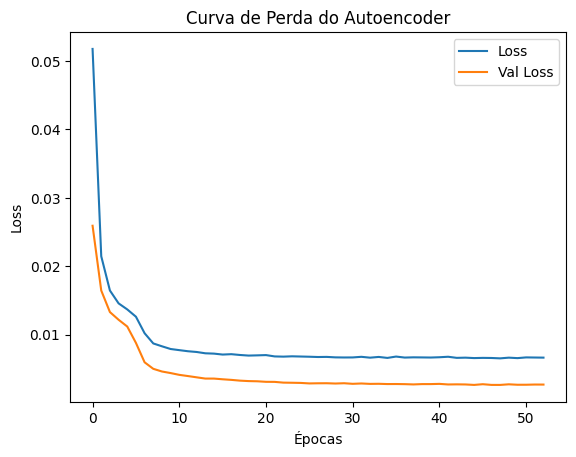

In [2]:
# Plotar a curva de perda (opcional)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Curva de Perda do Autoencoder')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [3]:
# Salvar o modelo completo no formato Keras
autoencoder.save('autoencoder_model.keras')


In [4]:
from tensorflow.keras.models import load_model

# Carregar o modelo treinado
autoencoder = load_model('autoencoder_model.keras')

# Resumo do modelo (opcional)
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 215 (864.00 B)

 Trainable params: 71 (284.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 144 (580.00 B)

In [5]:
# Gerar 100 dados anômalos
np.random.seed(42)
anomalous_data = pd.DataFrame({
    'Engine_speed': np.random.uniform(500, 3000, 100),
    'Engine_torque': np.random.uniform(0, 100, 100),
    'Flywheel_torque': np.random.uniform(-50, 200, 100),
    'Throttle_position_signal': np.random.uniform(5, 100, 100),
    'Vehicle_speed': np.random.uniform(0, 100, 100)
})

# Carregar e selecionar 100 registros normais do dataset
file_path = "datasetCAN.csv"
dataset = pd.read_csv(file_path, delimiter=',')
normal_data_sample = dataset.sample(n=100, random_state=22)

# Concatenar os dados normais e anômalos
combined_data = pd.concat([normal_data_sample, anomalous_data], ignore_index=True)

# Selecionar apenas as colunas esperadas pelo modelo
expected_columns = ['Engine_speed', 'Engine_torque', 'Flywheel_torque', 'Throttle_position_signal', 'Vehicle_speed']
combined_data = combined_data[expected_columns]
normal_data_sample = normal_data_sample[expected_columns]

# Normalizar os dados
scaler = MinMaxScaler()
combined_data_scaled = scaler.fit_transform(combined_data)

In [6]:
# Reconstruir os dados usando o Autoencoder
reconstructed = autoencoder.predict(combined_data_scaled)

# Calcular o erro de reconstrução para cada registro
reconstruction_error = np.mean((combined_data_scaled - reconstructed) ** 2, axis=1)

# Definir o threshold dinâmico
threshold_range = np.linspace(reconstruction_error.min(), reconstruction_error.max(), 100)

# Inicializar variáveis para armazenar o melhor resultado
best_threshold = None
best_normal_as_anomaly = float('inf')  # Minimizar falsos positivos
best_anomalous_detected = 0  # Maximizar verdadeiros positivos

# Iterar sobre possíveis valores de threshold
for threshold in threshold_range:
    anomalies_detected = reconstruction_error > threshold

    # Separar os dados normais e anômalos
    normal_as_anomaly = np.sum(anomalies_detected[:100])  # Falsos positivos
    anomalous_correctly_detected = np.sum(anomalies_detected[100:])  # Verdadeiros positivos

    # Atualizar o melhor threshold
    if (normal_as_anomaly < best_normal_as_anomaly or
        (normal_as_anomaly == best_normal_as_anomaly and anomalous_correctly_detected > best_anomalous_detected)):
        best_threshold = threshold
        best_normal_as_anomaly = normal_as_anomaly
        best_anomalous_detected = anomalous_correctly_detected

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [7]:
# Identificar anomalias com o melhor threshold
anomalies = reconstruction_error > best_threshold
combined_data['Is_Anomaly'] = anomalies

In [8]:
# Resultados finais
print(f"Melhor threshold: {best_threshold}")
print(f"Normais detectados como anomalias: {best_normal_as_anomaly}")
print(f"Anômalos detectados corretamente: {best_anomalous_detected}")

# Visualizar os dados
print("\nPrimeiros 5 dados com anomalias detectadas:")
print(combined_data[combined_data['Is_Anomaly']].head())

# Estatísticas gerais
num_total_anomalies = combined_data['Is_Anomaly'].sum()
print(f"\nTotal de anomalias detectadas: {num_total_anomalies} de 100")

Melhor threshold: 0.07504887808747103
Normais detectados como anomalias: 0
Anômalos detectados corretamente: 51

Primeiros 5 dados com anomalias detectadas:
     Engine_speed  Engine_torque  Flywheel_torque  Throttle_position_signal  \
101   2876.785766      63.641041       -28.965009                 55.478690   
102   2329.984855      31.435598        -9.592821                 56.360337   
105    889.986301      24.929223       -47.700737                 97.705948   
107   2665.440364      75.555114       115.875442                 35.680865   
108   2002.787529      22.879817       -48.734604                 80.542689   

     Vehicle_speed  Is_Anomaly  
101      90.255291        True  
102      50.525237        True  
105      89.552323        True  
107       1.083765        True  
108      90.538198        True  

Total de anomalias detectadas: 51 de 100
